In [1]:
import os
import numpy as np

TITANIC_FILEPATH = os.path.join('datasets', 'titanic')

In [2]:
import pandas as pd

def loading_titanic(filename, titanic_filepath=TITANIC_FILEPATH):
    csv_path = os.path.join(titanic_filepath, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = loading_titanic('train.csv')
test_data = loading_titanic('test.csv')

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train_data = train_data.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,male,22.0,1,0,7.2500
1,2,1,1,female,38.0,1,0,71.2833
2,3,1,3,female,26.0,0,0,7.9250
3,4,1,1,female,35.0,1,0,53.1000
4,5,0,3,male,35.0,0,0,8.0500


In [7]:
train_data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train_data.Parch.value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

In [9]:
train_data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [10]:
age_median = np.median(train_data.Age)
train_data.Age = train_data['Age'].fillna(age_median)

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('numeric selector', DataFrameSelector(['Age', 'Fare', 'SibSp', 'Parch'])),
    ('imputer', SimpleImputer(strategy='median'))
])

In [13]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  7.25  ,  1.    ,  0.    ],
       [38.    , 71.2833,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  1.    ,  2.    ],
       [26.    , 30.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    ,  0.    ]])

In [14]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('category selector', DataFrameSelector(['Pclass', 'Sex'])),
    ('imputer', MostFrequentImputer()),
    ('cat encoder', OneHotEncoder(sparse=False))
])

In [16]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 1., 0.],
       ...,
       [0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1.]])

In [17]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ('num pipeline', num_pipeline),
    ('cat pipeline', cat_pipeline)
])

In [18]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.    ,  7.25  ,  1.    , ...,  1.    ,  0.    ,  1.    ],
       [38.    , 71.2833,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  1.    ,  1.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  1.    , ...,  1.    ,  1.    ,  0.    ],
       [26.    , 30.    ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       [32.    ,  7.75  ,  0.    , ...,  1.    ,  0.    ,  1.    ]])

In [19]:
y_train = train_data.Survived

## SVC 

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

svm_clf = SVC()
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.6813233458177278

## RandomForestClassifier 

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8171535580524345

## Logistic Regression 

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
log_reg_scores.mean()

0.7890012484394507

## SGDClassifier

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_clf_scores.mean()

0.7541822721598003

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf_scores = cross_val_score(knn_clf, X_train, y_train, cv=10)
knn_clf_scores.mean()

0.7273533083645443

In [25]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf_scores = cross_val_score(decision_tree_clf, X_train, y_train, cv=10)
decision_tree_clf_scores.mean()

0.7811735330836453

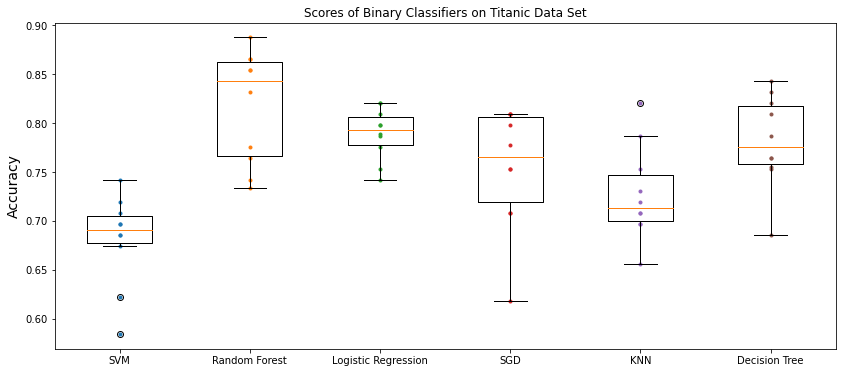

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.plot([3]*10, log_reg_scores, ".")
plt.plot([4]*10, sgd_clf_scores, ".")
plt.plot([5]*10, knn_clf_scores, ".")
plt.plot([6]*10, decision_tree_clf_scores, ".")
plt.boxplot([svm_scores, forest_scores, log_reg_scores, sgd_clf_scores, knn_clf_scores, decision_tree_clf_scores], 
            labels=("SVM","Random Forest", "Logistic Regression", 'SGD', 'KNN', 'Decision Tree'))
plt.ylabel("Accuracy", fontsize=14)
plt.title('Scores of Binary Classifiers on Titanic Data Set')
plt.show()

## SVM GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV

C = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
kernel = ['rbf', 'linear', 'poly', 'sigmoid']

svm_params = {
    'C': C,
    'gamma': gamma,
    'kernel': kernel
}

svm_clf = SVC(random_state=42)
svm_random = GridSearchCV(svm_clf, 
                          param_grid = svm_params, cv = 3, verbose=2, n_jobs = -1)

svm_random.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [ ]:
print("Best parameters: ", svm_random.best_params_)
print("Best score: ", svm_random.best_score_)

## Random Forest RandomizedSearchCV 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf_params = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}

forest_clf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = forest_clf, 
                               param_distributions = rf_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
print("Best parameters: ", rf_random.best_params_)
print("Best score: ", rf_random.best_score_)

## LogisticRegression RandomizedSearchCV 

In [ ]:
penalty = ['l2', 'l1', 'elasticnet']
C = [0.01, 0.1, 1]
solver = ['liblinear']
verbose = [1,3,5]

log_reg_params = {
    'penalty': penalty,
    'C': C,
    'solver': solver,
    'verbose': verbose
}

log_reg = LogisticRegression(random_state=42)
log_reg_random = RandomizedSearchCV(estimator = log_reg, 
                                    param_distributions = log_reg_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
log_reg_random.fit(X_train, y_train)

In [ ]:
print("Best parameters: ", log_reg_random.best_params_)
print("Best score: ", log_reg_random.best_score_)

## SGD Classifier RandomizedSearchCV 

In [ ]:
penalty = ['l2', 'l1', 'elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1, 1]
verbose = [1,3,5]

sgd_params = {
    'penalty': penalty,
    'alpha': alpha,
    'verbose': verbose
}

sgd_clf = SGDClassifier(random_state=42)
sgd_random = RandomizedSearchCV(estimator = sgd_clf, 
                                    param_distributions = sgd_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
sgd_random.fit(X_train, y_train)

In [ ]:
print("Best parameters: ", sgd_random.best_params_)
print("Best score: ", sgd_random.best_score_)

## KNN Classifier 

In [ ]:
n_neighbors = [3,5,7,9]
weights = ['uniform', 'distance']
p = [1, 2]

knn_params = {
    'n_neighbors': n_neighbors,
    'weights': weights, 
    'p': p
}

knn_clf = KNeighborsClassifier()
knn_random = RandomizedSearchCV(estimator = knn_clf, 
                                    param_distributions = knn_params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train, y_train)

In [ ]:
print("Best parameters: ", knn_random.best_params_)
print("Best score: ", knn_random.best_score_)

In [ ]:
import numpy as np

train_data['AgeCategory'] = pd.cut(train_data['Age'], 
                                   bins=[0, 15, 30, 45, 60, 75, np.inf],
                                   labels=[0, 15, 30, 45, 60, 75])

In [ ]:
train_data['AgeCategory'].hist();